# Estruturação Conceitual – Modelagem de Risco de Diabetes

Este trecho responde aos tópicos de fundamentação técnica, propondo o enquadramento do problema, os principais desafios e as ferramentas empregadas.

---

## 1. Enquadramento como Classificação Supervisionada
A predição de risco de diabetes configura-se naturalmente como tarefa de **classificação supervisionada** pelos seguintes motivos:

1. **Presença de rótulo binário**: a variável-alvo `Diabetes_binary` assume valores 0 (sem diagnóstico) ou 1 (diagnosticado), permitindo treinar o modelo com exemplos classificados.
2. **Disponibilidade de atributos explicativos**: indicadores clínicos (IMC, pressão arterial, colesterol), histórico de saúde cardiovascular e comportamentais (dieta, atividade física) formam variáveis de entrada que descrevem cada indivíduo.
3. **Objetivo de generalização**: espera-se que o modelo aprenda padrões nos dados rotulados e aplique esse conhecimento para prever o diagnóstico de novos entrevistados.

---

## 2. Desafios Técnicos

### 2.1 Desequilíbrio de Classes
Em amostras populacionais, há proporção muito maior de casos negativos. Sem tratamento adequado, o classificador tende a ignorar a classe minoritária.
- **Solução**: uso de `class_weight='balanced'`, reamostragem (SMOTE/undersampling) ou métricas focadas (F1-score, AUC-ROC).

### 2.2 Heterogeneidade de Escalas
Variáveis em diferentes unidades (ex.: IMC em kg/m², idade em anos) podem distorcer modelos sensíveis a magnitude.
- **Solução**: padronização via `StandardScaler` ou escala Min–Max.

---

## 3. Principais Bibliotecas

- **NumPy**: base para operações numéricas e manipulação eficiente de arrays.
- **pandas**: leitura, limpeza e transformação de conjuntos de dados tabulares.
- **scikit-learn**:
  - *Pré‑processamento*: `SimpleImputer`, `StandardScaler`, `OneHotEncoder`, `ColumnTransformer`.
  - *Modelagem*: `LogisticRegression`, `RandomForestClassifier`, `train_test_split`.
  - *Avaliação*: `classification_report`, `roc_auc_score`, `GridSearchCV`.
- **Matplotlib & seaborn**: geração de gráficos exploratórios e curvas ROC.
- **joblib**: serialização de pipelines e modelos treinados para produção.



c:\Users\jeany\.conda\envs\infnet_ml\Lib\site-packages\sklearn\compose\_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  Returns


Melhores parâmetros: {'classifier__C': 0.01, 'classifier__penalty': 'l1'}
              precision    recall  f1-score   support

           0       0.95      0.73      0.82     43667
           1       0.31      0.76      0.44      7069

    accuracy                           0.73     50736
   macro avg       0.63      0.74      0.63     50736
weighted avg       0.86      0.73      0.77     50736

AUC ROC: 0.8196


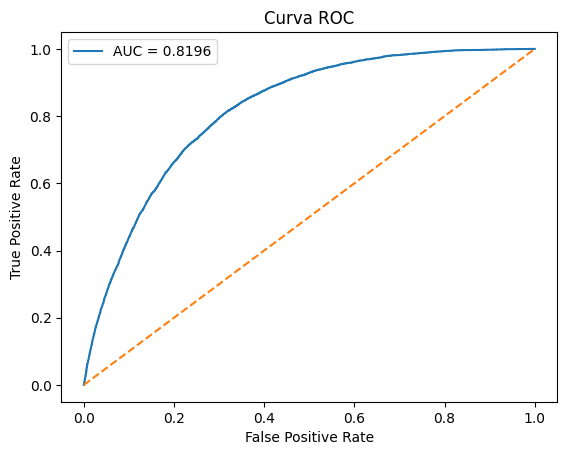

['model_pipeline_diabetes_corrigido.joblib']

In [38]:

import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Carregar dados do repositório UCI
cdc = fetch_ucirepo(id=891)
X = cdc.data.features
y = cdc.data.targets.squeeze()

# Identificar colunas numéricas e categóricas
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Pré-processamento
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Corrigir ColumnTransformer para aceitar force_int_remainder_cols como bool
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, num_cols),
        ('cat', categorical_pipeline, cat_cols)
    ],
    remainder='drop',
    force_int_remainder_cols=False
)

# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Construir pipeline de modelagem
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        solver='liblinear',
        max_iter=1000,
        class_weight='balanced'
    ))
])

# Definir grade de hiperparâmetros para GridSearch
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2']
}

grid_search = GridSearchCV(
    model_pipeline,
    param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Melhores parâmetros:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Avaliação
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(f'AUC ROC: {roc_auc_score(y_test, y_proba):.4f}')

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.4f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.show()

# Salvar modelo
joblib.dump(best_model, 'model_pipeline_diabetes_corrigido.joblib')
